In [1]:
import numpy as np
import matrixmethod as mm
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2

! pip install sympy

import sympy as sp;

## The bridge

![a figure](./figures/bridge_%20L723.png)

In [2]:
# defining parameters

L = 11.75                # m
h = 4                    # m
F = 500                  # kN
F_x = F * (4/5)          # kN
F_z = F * (3/5)          # kN
q = 20                   # kN/m
EI = 400 * 10**3         # kNm^2
EI_tr = 10**-100         # kNm^2
EA = 1.3 * 10**6         # kN
w_0 = 0.1                # m 

# clean all nodes 

mm.Node.clear()
mm.Element.clear()

# defining nodes

nodes = []

nodes.append(mm.Node(0, 0))
nodes.append(mm.Node(L, 0))
nodes.append(mm.Node(2 * L, 0))
nodes.append(mm.Node(3* L, 0))
nodes.append(mm.Node(4 * L, 0))

nodes.append(mm.Node(4 * L, -h))
nodes.append(mm.Node(4 * L, 2 * -h))
nodes.append(mm.Node(4 * L, 3* -h))
nodes.append(mm.Node(4 * L, 4 * -h))

nodes.append(mm.Node(4 * L + h, -3* h))
nodes.append(mm.Node(4 * L + h, -2* h))
nodes.append(mm.Node(4 * L + h,  -h))
nodes.append(mm.Node(4 * L + h, 0))
nodes.append(mm.Node(4 * L + h,  h))

# define element

elems = []

## beam 
elems.append(mm.Element(nodes[0], nodes[1]))
elems.append(mm.Element(nodes[1], nodes[2]))
elems.append(mm.Element(nodes[2], nodes[3]))
elems.append(mm.Element(nodes[3], nodes[4]))

## truss
elems.append(mm.Element(nodes[4], nodes[5]))
elems.append(mm.Element(nodes[5], nodes[6]))
elems.append(mm.Element(nodes[6], nodes[7]))
elems.append(mm.Element(nodes[7], nodes[8]))
elems.append(mm.Element(nodes[8], nodes[9]))
elems.append(mm.Element(nodes[9], nodes[10]))
elems.append(mm.Element(nodes[10], nodes[11]))
elems.append(mm.Element(nodes[11], nodes[12]))
elems.append(mm.Element(nodes[12], nodes[13]))
elems.append(mm.Element(nodes[4], nodes[13]))
elems.append(mm.Element(nodes[4], nodes[12]))
elems.append(mm.Element(nodes[4], nodes[11]))
elems.append(mm.Element(nodes[5], nodes[11]))
elems.append(mm.Element(nodes[6], nodes[11]))
elems.append(mm.Element(nodes[6], nodes[10]))
elems.append(mm.Element(nodes[6], nodes[9]))
elems.append(mm.Element(nodes[7], nodes[9]))

## cables 
elems.append(mm.Element(nodes[1], nodes[8]))
elems.append(mm.Element(nodes[2], nodes[7]))
elems.append(mm.Element(nodes[3], nodes[6]))


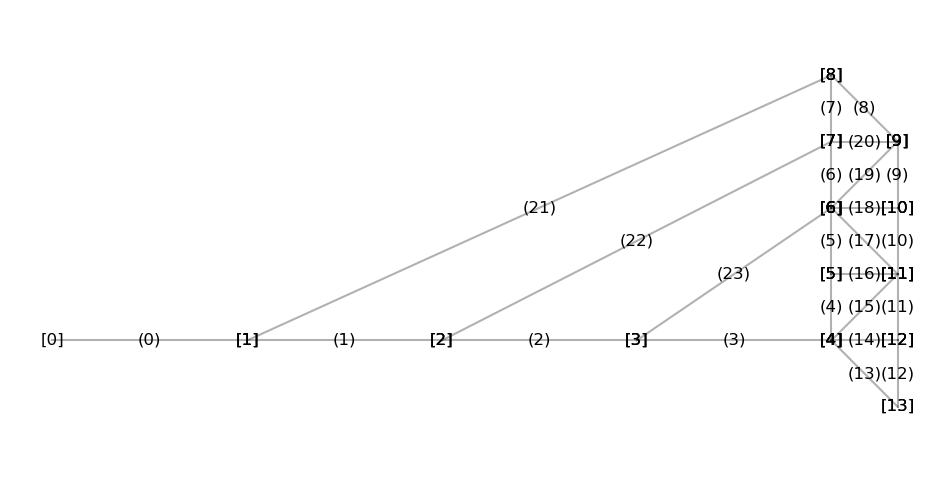

In [3]:
plt.figure(figsize=(12, 6))
elements_number = np.arange(len(elems))
for elem in zip(elems, elements_number):
    elem[0].plot_numbered_structure(elem[1])

plt.savefig('nodes_elements_defining.png')

In [4]:
# truss and cables have the same properties 

# set_sections
beams = {}
truss = {}

beams['EI'] = EI
beams['EA'] = EA

truss['EA'] = EA
truss['EI'] = EI_tr

for i in range(len(elems)):
    if i < 4:
        elems[i].set_section(beams)
    else:
        elems[i].set_section(truss)



In [5]:
# Adding the loads 
nodes[9].add_load([F_x, F_z, 0])
nodes[10].add_load([F_x, F_z, 0])
nodes[11].add_load([F_x, F_z, 0])

for i in range(4):
    elems[i].add_distributed_load([0, q])


In [6]:
# defining the constrains
con = mm.Constrainer()
con.fix_dof(nodes[0], 1, w_0)
con.fix_dof(nodes[13], 0)
con.fix_dof(nodes[13], 1)

In [7]:
global_k = np.zeros ((3*len(nodes), 3*len(nodes)))
global_f = np.zeros (3*len(nodes))

for e in elems:
    elmat = e.stiffness()
    idofs = e.global_dofs()
    global_k[np.ix_(idofs,idofs)] += elmat

for n in nodes:
    global_f[n.dofs] += n.p

Kff, Ff = con.constrain ( global_k, global_f )
u = np.matmul ( np.linalg.inv(Kff), Ff )
print(u) # in m

[-0.00454575 -0.03375181 -0.00454575  0.38454161 -0.00852495 -0.00460226
  0.31259962  0.01357086 -0.01076561  0.16045391  0.01145538 -0.02069145
  0.03113487  0.01247095 -0.04838331  0.03488135  0.00731792 -0.08704926
  0.03862782  0.00973863 -0.12665653  0.03971737  0.00911702 -0.16082451
  0.03974533  0.00915058 -0.12457761  0.00355284  0.0091875  -0.0858185
  0.00351639  0.00944309 -0.04838331  0.00255686  0.00789464 -0.02069145
  0.00127843  0.00566428  0.00432853]


In [8]:
print(f'The vertical support reation at node 0 is {con.support_reactions(global_k,u,global_f)[0]} kN')
print(f'The horizontal support reation at node 13 is {con.support_reactions(global_k,u,global_f)[1]} kN')
print(f'The vertical support reation at node 13 is {con.support_reactions(global_k,u,global_f)[2]} kN')

The vertical support reation at node 0 is -224.50980392158039 kN
The horizontal support reation at node 13 is -1199.9999999999864 kN
The vertical support reation at node 13 is -1615.490196078445 kN


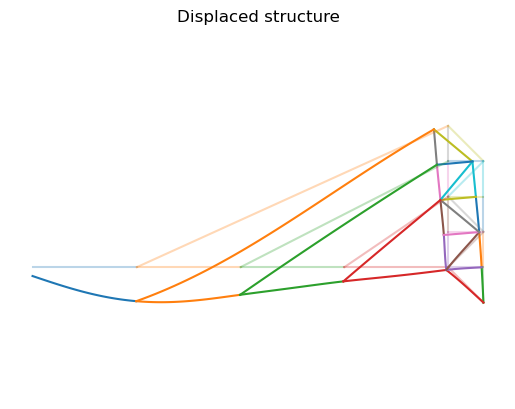

In [9]:
for elem in elems:
    u_elem = con.full_disp(u)[elem.global_dofs()]
    elem.plot_displaced(u_elem,num_points=51,global_c=True,scale=10)
plt.savefig('displaced structure.png')

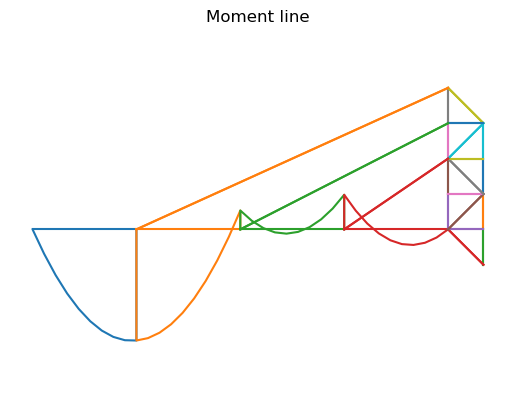

In [10]:
for elem in elems:
    u_elem = con.full_disp(u)[elem.global_dofs()]
    elem.plot_moment_diagram(u_elem,num_points=10,global_c=True,scale=0.01)
plt.savefig('Moment_diagram.png')

In [11]:
# DOF's of nodes
U_nodes = []

U_nodes.append([-0.00454575, 0.1, -0.03375181])
U_nodes.append([-0.00454575, 0.38454161, -0.00852495])
U_nodes.append([-0.00460226, 0.31259962, 0.01357086])
U_nodes.append([-0.01076561, 0.16045391, 0.01145538])
U_nodes.append([-0.02069145, 0.03113487, 0.01247095])
U_nodes.append([-0.04838331, 0.03488135, 0.00731792])
U_nodes.append([-0.08704926, 0.03862782, 0.00973863])
U_nodes.append([-0.12665653, 0.03971737, 0.00911702])
U_nodes.append([-0.16082451, 0.03974533, 0.00915058])
U_nodes.append([-0.12457761, 0.00355284, 0.0091875])
U_nodes.append([-0.0858185, 0.00351639, 0.00944309])
U_nodes.append([-0.04838331, 0.00255686, 0.00789464])
U_nodes.append([-0.02069145, 0.00127843, 0.00566428])
U_nodes.append([0, 0, 0.00432853])

In [12]:
# U_elem0 = U_nodes[0] + U_nodes[1]
# elems[0].bending_moments(U_elem0,num_points=2)

# elements from 0 to 12:
U_elems = []
for i in range(1, len(U_nodes)):
    U_elems.append(U_nodes[i-1] + U_nodes[i])

U_elems.append(U_nodes[4] + U_nodes[12])
U_elems.append(U_nodes[4] + U_nodes[11])
U_elems.append(U_nodes[5] + U_nodes[11])
U_elems.append(U_nodes[6] + U_nodes[11])
U_elems.append(U_nodes[6] + U_nodes[10])
U_elems.append(U_nodes[6] + U_nodes[9])
U_elems.append(U_nodes[7] + U_nodes[9])
U_elems.append(U_nodes[1] + U_nodes[8])
U_elems.append(U_nodes[2] + U_nodes[7])
U_elems.append(U_nodes[3] + U_nodes[6])

# calculating the moment at the start and at the end of the element:

moment = []
moment_10 = []
for i in range(len(U_elems)):
    moment.append(elems[i].bending_moments(U_elems[i],num_points=2))
    if i < 4:
        moment_10.append(elems[i].bending_moments(U_elems[i],num_points=25))

In [13]:
# Element zero

x = np.linspace(0, L, 25)

# Bending Moment an shear Calculation
moment_line = (q/2) * x**2 + con.support_reactions(global_k, u, global_f)[0] * x

shear_force = q * x + con.support_reactions(global_k, u, global_f)[0]

# plt.figure(figsize=(6, 2))
# plt.plot(x, moment_line, label="Bending Moment", color="blue")
# plt.grid()
# plt.figure(figsize=(6, 2))
# plt.plot(x, shear_force, label="Shear force", color="red")
# plt.grid();

print(f'The moment at the begin of element zero is {moment[0][0]} kNm')
print(f'The moment at the   end of element zero is {moment[0][1]} kNm')
print()
print(f'The shear force at the begin of element zero is {shear_force[0]} kN')
print(f'The shear force at the end   of element zero is {shear_force[-1]} kN')

The moment at the begin of element zero is -0.0004527689752934248 kNm
The moment at the   end of element zero is 1257.3655662441536 kNm

The shear force at the begin of element zero is -224.50980392158039 kN
The shear force at the end   of element zero is 10.490196078419615 kN


In [22]:
(- moment[1][1] + moment[0][1] - q * (L**2/2))/L

np.float64(7.652648180075727)

In [ ]:
print(elems[0].shear_force(U_elems[0],num_points=2))
print(elems[1].shear_force(U_elems[1],num_points=2))
print(elems[2].shear_force(U_elems[2],num_points=2))
print(elems[3].shear_force(U_elems[3],num_points=2))
print(elems[4].shear_force(U_elems[4],num_points=2))

[224.50987396 -10.49012604]
[  -7.65262476 -242.65262476]
[ 102.36073259 -132.63926741]
[150.78194423 -84.21805577]
[2.2286025e-103 2.2286025e-103]


In [ ]:
# def normal_force(self, u_global, num_points=2):
#     """
#     Calculates the normal (axial) force along the element.

#     Parameters:
#     - u_global (numpy.ndarray): Global displacement vector.
#     - num_points (int): Number of points to evaluate the normal force. Default is 2.

#     Returns:
#     - N (numpy.ndarray): Array of normal forces at the specified points.
#     """
#     L = self.L
#     q_x = self.q[0]
#     EA = self.EA

#     local_x = np.linspace(0.0, L, num_points)
#     local_disp = np.matmul(self.T, u_global)

#     u_1 = local_disp[0]
#     u_2 = local_disp[3]

#     N = q_x * (L / 2.0 - local_x) + EA / L * (u_2 - u_1)
#     return N

In [15]:
# Element zero

x = np.linspace(0, L, 25)

# Bending Moment an shear Calculation
moment_line = (q/2) * x**2 + con.support_reactions(global_k, u, global_f)[0] * x

shear_force = q * x + con.support_reactions(global_k, u, global_f)[0]

# plt.figure(figsize=(6, 2))
# plt.plot(x, moment_line, label="Bending Moment", color="blue")
# plt.grid()
# plt.figure(figsize=(6, 2))
# plt.plot(x, shear_force, label="Shear force", color="red")
# plt.grid();

print(f'The moment at the begin of element zero is {moment[0][0]} kNm')
print(f'The moment at the   end of element zero is {moment[0][1]} kNm')
print()
print(f'The shear force at the begin of element zero is {shear_force[0]} kN')
print(f'The shear force at the end   of element zero is {shear_force[-1]} kN')

The moment at the begin of element zero is -0.0004527689752934248 kNm
The moment at the   end of element zero is 1257.3655662441536 kNm

The shear force at the begin of element zero is -224.50980392158039 kN
The shear force at the end   of element zero is 10.490196078419615 kN
